In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [13]:
df = pd.read_csv("/content/drive/MyDrive/DL_4_NLP_Cau_2024/data/wine-reviews.csv"
, usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [14]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [15]:
df = df.dropna(subset=["description", "points"])

In [16]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [17]:
df.tail()

,country,description,points,price,variety,winery
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Pinot Gris,Domaine Marcel Deiss
129970,France,"Big, rich and off-dry, this is powered by inte...",90,21.0,Gewürztraminer,Domaine Schoffit


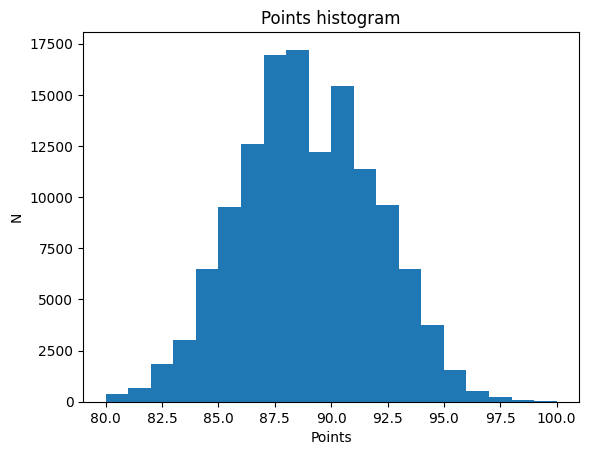

In [18]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [19]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [20]:
df

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0
...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1


In [21]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [22]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [23]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [25]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [26]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.29697534, -0.42517978,  0.15413123, ...,  0.17649326,
        -0.10698403,  0.09628087],
       [ 0.4726735 , -0.14838366,  0.15166561, ..., -0.12469874,
        -0.3972304 , -0.00235184],
       [ 0.20507826, -0.16215988,  0.0386988 , ..., -0.04016306,
        -0.345995  ,  0.11616279],
       ...,
       [ 0.32380012,  0.1450126 ,  0.02279238, ..., -0.15971363,
        -0.20424937,  0.12429205],
       [ 0.20006862, -0.3300519 ,  0.03661179, ..., -0.07414044,
        -0.19625998,  0.03105962],
       [ 0.5789546 , -0.28627485, -0.00404352, ...,  0.0469026 ,
        -0.05855664,  0.03377537]], dtype=float32)>

In [27]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [29]:
model.evaluate(train_data)

102/102 [==============================] - 2s 15ms/step - loss: 0.6874 - accuracy: 0.5709


[0.687406063079834, 0.5709202289581299]

In [30]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 11ms/step - loss: 0.6873 - accuracy: 0.5677


[0.6873165965080261, 0.5676694512367249]

In [31]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 145s 1s/step - loss: 0.6285 - accuracy: 0.6428 - val_loss: 0.5136 - val_accuracy: 0.7746
Epoch 2/5
102/102 [==============================] - 136s 1s/step - loss: 0.4850 - accuracy: 0.7645 - val_loss: 0.4053 - val_accuracy: 0.8150
Epoch 3/5
102/102 [==============================] - 135s 1s/step - loss: 0.4087 - accuracy: 0.8244 - val_loss: 0.3821 - val_accuracy: 0.8226
Epoch 4/5
102/102 [==============================] - 138s 1s/step - loss: 0.3696 - accuracy: 0.8448 - val_loss: 0.3778 - val_accuracy: 0.8238
Epoch 5/5
102/102 [==============================] - 134s 1s/step - loss: 0.3438 - accuracy: 0.8561 - val_loss: 0.3785 - val_accuracy: 0.8275


In [32]:
model.evaluate(test_data)

13/13 [==============================] - 3s 232ms/step - loss: 0.3755 - accuracy: 0.8280


[0.3755160868167877, 0.8279735445976257]

# LSTM

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 186ms/step - loss: 0.6927 - accuracy: 0.5360


[0.6927294731140137, 0.5360468029975891]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 96s 503ms/step - loss: 0.5570 - accuracy: 0.7030 - val_loss: 0.3759 - val_accuracy: 0.8258
Epoch 2/5
102/102 [==============================] - 52s 506ms/step - loss: 0.3704 - accuracy: 0.8342 - val_loss: 0.3480 - val_accuracy: 0.8387
Epoch 3/5
102/102 [==============================] - 52s 511ms/step - loss: 0.3501 - accuracy: 0.8445 - val_loss: 0.3502 - val_accuracy: 0.8374
Epoch 4/5
102/102 [==============================] - 57s 553ms/step - loss: 0.3426 - accuracy: 0.8468 - val_loss: 0.3453 - val_accuracy: 0.8396
Epoch 5/5
102/102 [==============================] - 52s 507ms/step - loss: 0.3386 - accuracy: 0.8486 - val_loss: 0.3424 - val_accuracy: 0.8415


In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 4s 273ms/step - loss: 0.3497 - accuracy: 0.8416


[0.3497326672077179, 0.8415910005569458]